In [11]:
%matplotlib inline


from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.decomposition import tICA
from msmbuilder.preprocessing import RobustScaler
#from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import KCenters
from msmbuilder.msm import MarkovStateModel

import numpy as np

import msmexplorer as msme

rs = np.random.RandomState(42)

In [12]:
from msmbuilder.dataset import dataset
import os
import mdtraj as mdt
import glob


cwd = os.getcwd()
print(cwd)

## Load
trajs = dataset("*SC*.xtc", topology="md.loop_SC_start.gro")
    
for traj in trajs:
    print(traj)

/Users/sbamos/Documents/WORK/MSM
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>


In [13]:
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = featurizer.fit_transform(trajs)

In [14]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(diheds)

(5, 5001, 2)


/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


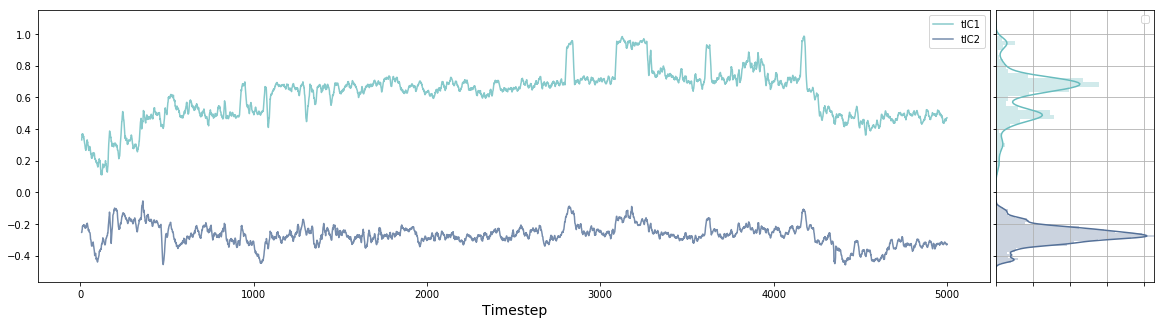

In [15]:
tica_model = tICA(lag_time=10, n_components=2, kinetic_mapping=True)
tica_trajs = tica_model.fit_transform(scaled_data)

print(np.shape(tica_trajs))

ax, side_ax = msme.plot_trace(tica_trajs[0][:, 0], window=10,
                              label='tIC1', xlabel='Timestep')
_ = msme.plot_trace(tica_trajs[0][:, 1], window=10, label='tIC2',
                    xlabel='Timestep', color='rawdenim', ax=ax,
                    side_ax=side_ax)
#__ = msme.plot_trace(tica_trajs[0][:, 2], window=10, label='tIC3',
#                    xlabel='Timestep', color='dijon', ax=ax,
#                    side_ax=side_ax)
#___ = msme.plot_trace(tica_trajs[0][:, 3], window=10, label='tIC4',
#                    xlabel='Timestep', color='carbon', ax=ax,
#                    side_ax=side_ax)
#____ = msme.plot_trace(tica_trajs[0][:, 4], window=10, label='tIC5',
#                    xlabel='Timestep', color='pomegranate', ax=ax,
#                    side_ax=side_ax)

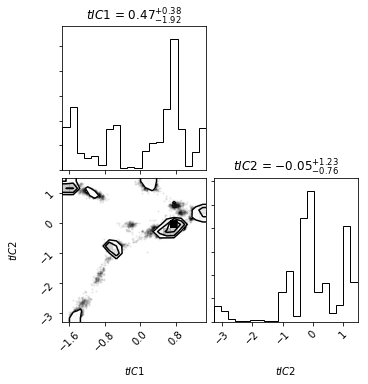

In [16]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx, labels=['$tIC1$', '$tIC2$', '$tIC3$', '$tIC4$', '$tIC5$'],
                    show_titles=True)

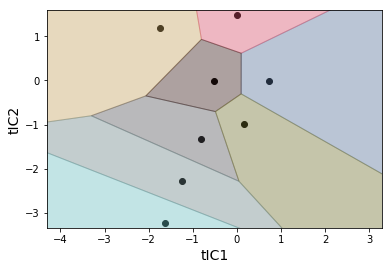

In [17]:
clusterer = KCenters(n_clusters=8, random_state=rs)
clustered_trajs = clusterer.fit_transform(tica_trajs)

_ = msme.plot_voronoi(clusterer, xlabel='tIC1', ylabel='tIC2')

MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%


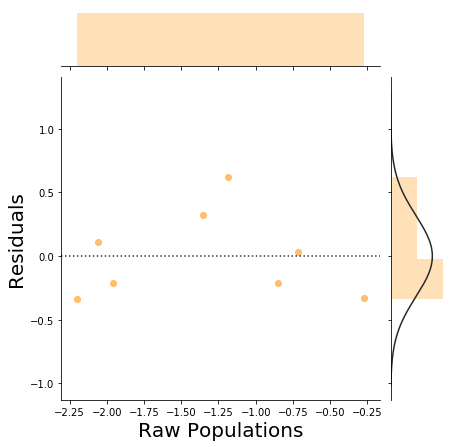

In [18]:
msm = MarkovStateModel(lag_time=20, n_timescales=5)
assigns = msm.fit_transform(clustered_trajs)

_ = msme.plot_pop_resids(msm, color='tarragon')

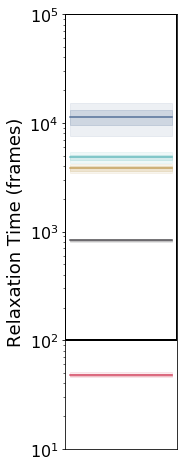

In [19]:
_ = msme.plot_timescales(msm, ylabel=r'Relaxation Time (frames)')

In [21]:
msm_list = [
    MarkovStateModel(lag_time=x, n_timescales=5, verbose=False)
                     for x in [1, 5, 25, 50, 100, 125 ]
]

for msm in msm_list:
    msm.fit(clustered_trajs)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


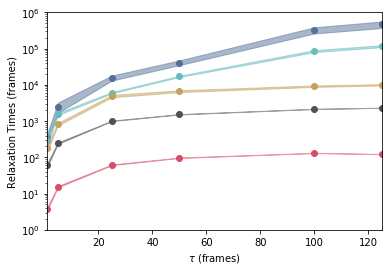

In [22]:
_ = msme.plot_implied_timescales(msm_list,
                                  xlabel=r'$\tau$ (frames)',
                                  ylabel='Relaxation Times (frames)')

In [23]:
msm = msm_list[2]  # Choose the appropriate MSM from the list

In [24]:
for i, (ts, ts_u) in enumerate(zip(msm.timescales_, msm.uncertainty_timescales())):
    timescale_ns = ts * 50 / 1000
    uncertainty_ns = ts_u * 50 / 1000
    print('Timescale %d: %.2f ± %.2f ns' % ((i + 1), timescale_ns, uncertainty_ns))

Timescale 1: 778.92 ± 122.03 ns
Timescale 2: 304.39 ± 12.85 ns
Timescale 3: 245.29 ± 18.81 ns
Timescale 4: 50.82 ± 0.77 ns
Timescale 5: 3.11 ± 0.07 ns


[[  7.21593602e-01  -3.32068554e-03]
 [ -1.62351620e+00  -3.24146330e+00]
 [ -1.74117042e+00   1.19609348e+00]
 [ -8.22152115e-01  -1.32497560e+00]
 [ -3.24385547e-03   1.48956413e+00]
 [ -5.23586565e-01  -2.11640270e-03]
 [  1.58965442e-01  -9.93914150e-01]
 [ -1.24858441e+00  -2.28609471e+00]]


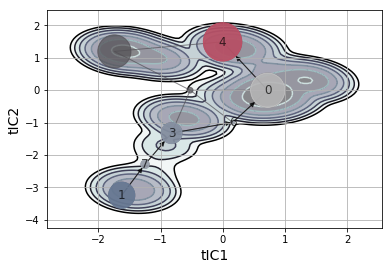

In [30]:
data = np.concatenate(tica_trajs, axis=0)
pi_0 = msm.populations_[np.concatenate(assigns, axis=0)]

# Free Energy Surface
ax = msme.plot_free_energy(data, obs=(0, 1), n_samples=10000,
                          pi=pi_0, gridsize=100, vmax=5.,
                          n_levels=8, cut=5, xlabel='tIC1',
                          ylabel='tIC2', random_state=rs)
print(clusterer.cluster_centers_)
# MSM Network
pos = dict(zip(range(clusterer.n_clusters), clusterer.cluster_centers_))
_ = msme.plot_msm_network(msm, pos=pos, node_color='carbon',
                          with_labels=False)

# Top Transition Pathway
w = (msm.left_eigenvectors_[:, 1] - msm.left_eigenvectors_[:, 1].min())
w /= w.max()
cmap = msme.utils.make_colormap(['rawdenim', 'lightgrey', 'pomegranate'])
_ = msme.plot_tpaths(msm, [1], [4], pos=pos, node_color=cmap(w),
                     alpha=.7, edge_color='black', ax=ax)